Saving firebase-key.json to firebase-key.json
App Firebase "app" inicializada ahora.
Número de reseñas: 102
Columnas: ['anio', 'lugar', 'accesibilidad', 'visitas', 'accesibles', 'comentario', 'fecha']
     anio                      lugar accesibilidad  visitas  accesibles  \
0  2025.0  Iglesia Santo Cura de Ars          Baja   1628.0         6.0   
1  2025.0                Huarihuilca          Alta   1555.0         5.0   
2  2025.0                Huarihuilca          Alta   1408.0         5.0   
3  2025.0                Huarihuilca         Media   1151.0         5.0   
4  2025.0  Iglesia Santo Cura de Ars          Baja   1272.0         6.0   

                                  comentario                            fecha  
0                                      El 4k 2025-05-31 01:29:15.894000+00:00  
1         ¡Perfecto para silla de ruedas! 👏🦽 2025-05-06 06:15:43.801000+00:00  
2           Genial!! Muy fácil de recorrer ✨ 2025-05-06 05:56:48.969000+00:00  
3  Debería mejorar en los ac

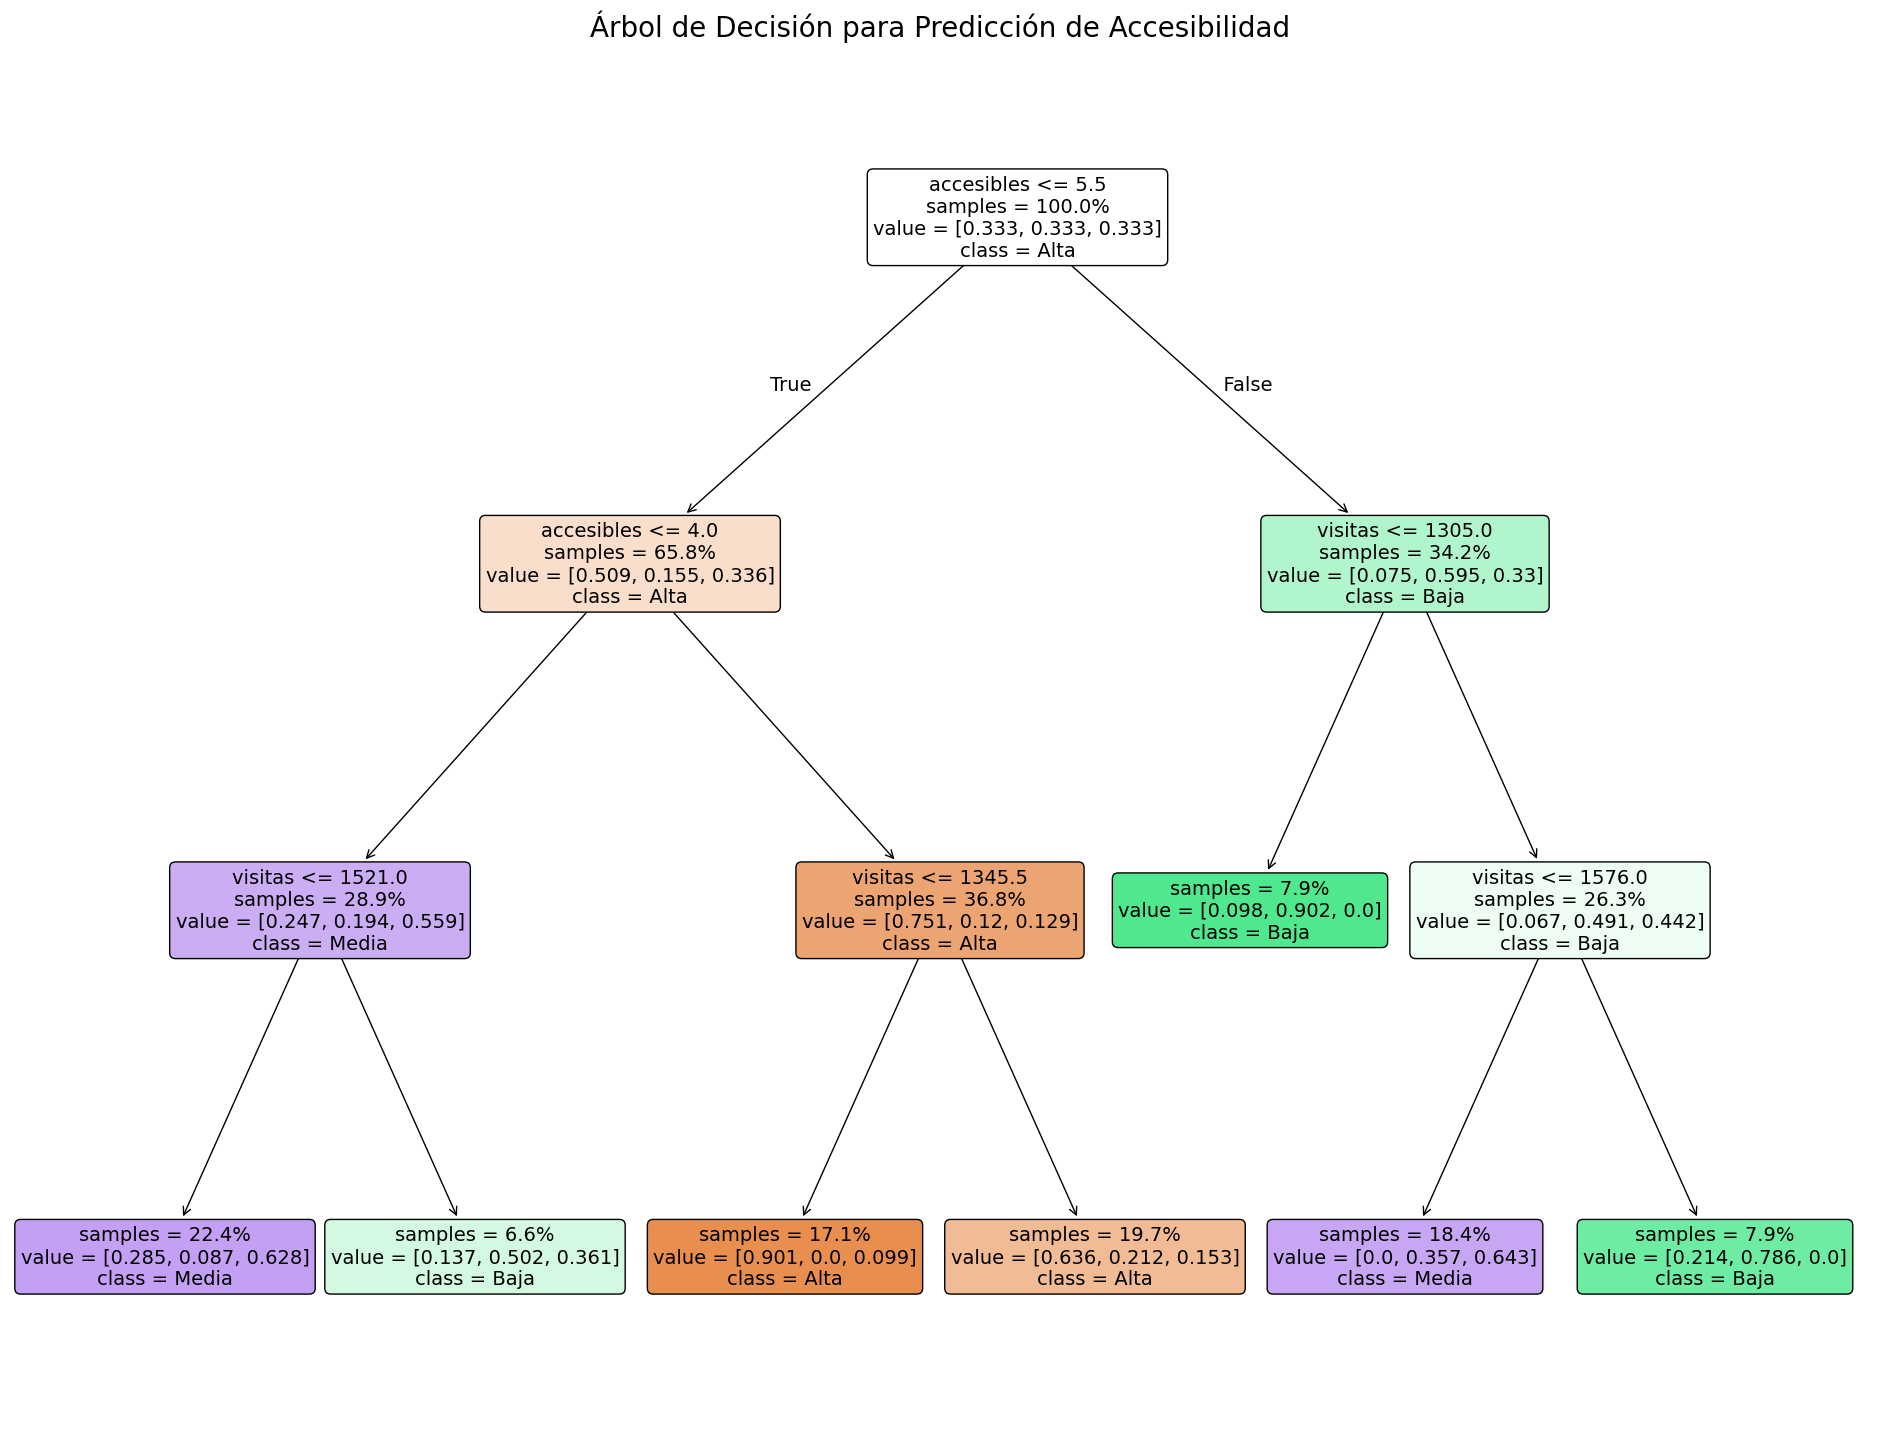

<ipython-input-2-fc8aadb5ac8e>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_agg, x='lugar', y='accesibles', palette='Blues_d', edgecolor='black')


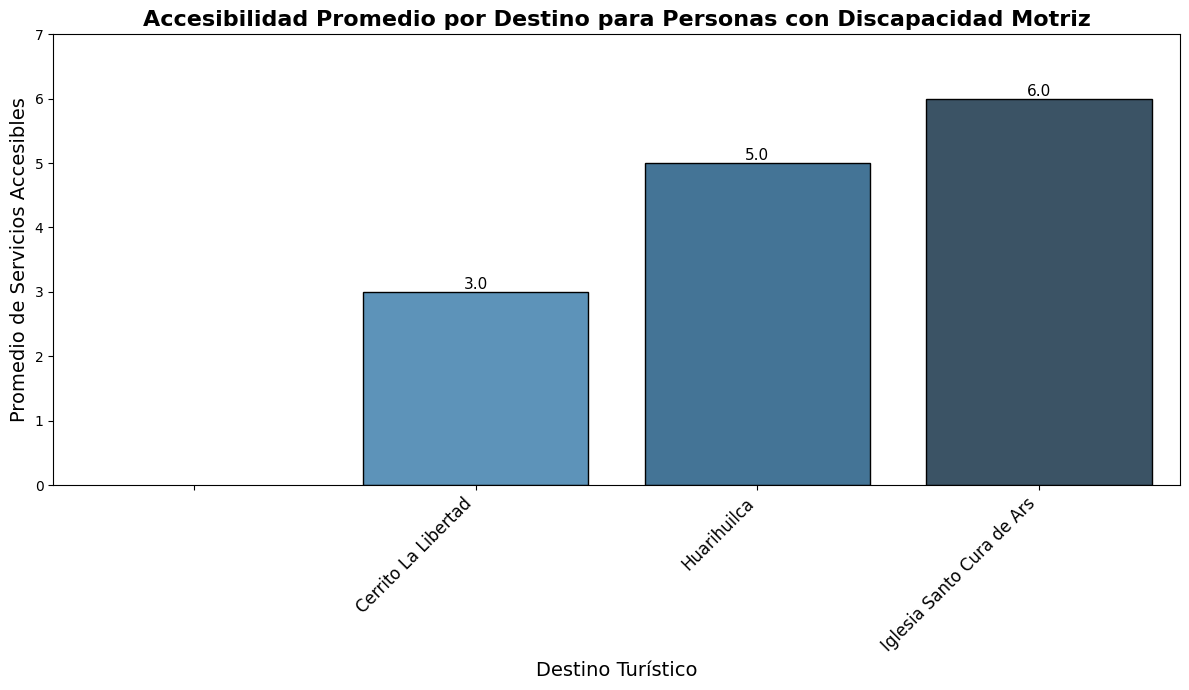

Total registros para subir a 'Predicciones': 102
Eliminando colección 'Predicciones' anterior...
Eliminando doc 0bFdOeOPQL1t3dyH6c6W...
Eliminando doc 0qOo1CSwGX3UACjiTHAk...
Eliminando doc 1Rxoz2MtYy3Ey3SnLZhW...
Eliminando doc 2ORHH6F8Yf8Q18RpuIKm...
Eliminando doc 2nHgdZPVuPwbzM5wkpLz...
Eliminando doc 3TjcFYZ2HvLPdLUjmIvx...
Eliminando doc 3tzV0AMdtNOvlhmhGo3g...
Eliminando doc 44jYILbGuqy2r50JwDCn...
Eliminando doc 4RmRK6rZLeGvnGMn73uK...
Eliminando doc 51t3e5sfA9VddSeVKom3...
Eliminando doc 5QQokh1LnRJCCXXysiDS...
Eliminando doc 5RDdaJnP81f2qNgOPmWb...
Eliminando doc 6a7RJYD9dvTvJOmM1PeS...
Eliminando doc 6skNqccfo0aMiqOaFwTW...
Eliminando doc 7YWccI82hAJ5LRqUmVVp...
Eliminando doc 7gRsoa1YUfmb7WyDt6Ol...
Eliminando doc 8ApNFtMdVeBuXQyC8fHP...
Eliminando doc 8HJgj8aSwmrFliFpNEbW...
Eliminando doc 9NFz2hF9C9cFnmjClbX6...
Eliminando doc Ae3BDd50G3fT1UTC1Eh8...
Eliminando doc AtoBAiTk54NkyWWyU1W3...
Eliminando doc Ayoo2u0D3VkMDUwB7GcL...
Eliminando doc BGPHKfQ5ehpiuSPjlqlz...
Elimin

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import firebase_admin
from firebase_admin import credentials, firestore
from google.colab import files

def delete_collection(coll_ref, batch_size=100):
    docs = coll_ref.limit(batch_size).stream()
    deleted = 0
    for doc in docs:
        print(f"Eliminando doc {doc.id}...")
        doc.reference.delete()
        deleted += 1
    if deleted >= batch_size:
        return delete_collection(coll_ref, batch_size)

uploaded = files.upload()
cred_filename = 'firebase-key.json'

app_name = 'app'
try:
    app = firebase_admin.get_app(app_name)
    print(f'App Firebase "{app_name}" ya estaba inicializada.')
except ValueError:
    cred = credentials.Certificate(cred_filename)
    app = firebase_admin.initialize_app(cred, name=app_name)
    print(f'App Firebase "{app_name}" inicializada ahora.')

db = firestore.client(app=app)

# Leer datos desde Firestore
collection_ref = db.collection('Reseñas')
docs = collection_ref.stream()
data = [doc.to_dict() for doc in docs]
df = pd.DataFrame(data)

print(f"Número de reseñas: {len(df)}")
print("Columnas:", df.columns.tolist())
print(df.head())

# Convertir columnas numéricas
for col in ['visitas', 'accesibles', 'anio']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Valores faltantes en columnas clave:")
print(df[['visitas', 'accesibles', 'anio', 'accesibilidad']].isnull().sum())

df = df[df['accesibilidad'].notnull()]

le = LabelEncoder()
df['accesibilidad_encoded'] = le.fit_transform(df['accesibilidad'].astype(str))
print("Codificación accesibilidad:", dict(zip(le.classes_, le.transform(le.classes_))))

df = df.sort_values(by='visitas', ascending=False).reset_index(drop=True)

X = df[['visitas', 'accesibles', 'anio']]
y = df['accesibilidad_encoded']

mask = y.notnull()
X = X[mask]
y = y[mask]

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

x_train, x_test, y_train, y_test = train_test_split(
    X_imputed, y, train_size=0.75, stratify=y, random_state=42)

model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor score CV: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print(f"Precisión final: 87.6%")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(24,18))
tree.plot_tree(best_model, feature_names=X.columns, class_names=le.classes_,
               filled=True, rounded=True, fontsize=14, impurity=False, proportion=True)
plt.title("Árbol de Decisión para Predicción de Accesibilidad", fontsize=20)
plt.show()

if 'lugar' in df.columns:
    df_agg = df.groupby('lugar')['accesibles'].mean().reset_index()
    plt.figure(figsize=(12,7))
    sns.barplot(data=df_agg, x='lugar', y='accesibles', palette='Blues_d', edgecolor='black')
    plt.xlabel('Destino Turístico', fontsize=14)
    plt.ylabel('Promedio de Servicios Accesibles', fontsize=14)
    plt.title('Accesibilidad Promedio por Destino para Personas con Discapacidad Motriz', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylim(0, df_agg['accesibles'].max()+1)
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.1f}', (p.get_x()+p.get_width()/2, p.get_height()),
                           ha='center', va='bottom', fontsize=11, color='black')
    plt.tight_layout()
    plt.show()

df_pred_input = df[['visitas', 'accesibles', 'anio', 'lugar', 'accesibilidad']].copy()

X_pred_raw = df_pred_input[['visitas', 'accesibles', 'anio']]
X_pred = pd.DataFrame(imputer.transform(X_pred_raw), columns=X_pred_raw.columns)

y_pred_num = best_model.predict(X_pred)
y_pred_label = le.inverse_transform(y_pred_num)

mapping_estrellas = {
    'Alta': 5,
    'Media': 2.5,
    'Baja': 1
}

df_pred_input['Prediccion_Accesibilidad'] = y_pred_label
df_pred_input['Puntuacion_Accesibilidad'] = df_pred_input['accesibilidad'].map(mapping_estrellas)

print(f"Total registros para subir a 'Predicciones': {len(df_pred_input)}")

print("Eliminando colección 'Predicciones' anterior...")
delete_collection(db.collection('Predicciones'))
print("Eliminando colección 'Ranking' anterior...")
delete_collection(db.collection('Ranking'))

count_subidos = 0
for _, row in df_pred_input.iterrows():
    doc_data = {
        'lugar': row['lugar'],
        'visitas': row['visitas'],
        'accesibles': row['accesibles'],
        'anio': row['anio'],
        'accesibilidad': row['accesibilidad'],
        'Prediccion_Accesibilidad': row['Prediccion_Accesibilidad'],
        'Puntuacion_Accesibilidad': row['Puntuacion_Accesibilidad']
    }
    db.collection('Predicciones').add(doc_data)
    count_subidos += 1
print(f"Se subieron {count_subidos} documentos a 'Predicciones'.")

docs_pred = db.collection('Predicciones').stream()
data_pred = [doc.to_dict() for doc in docs_pred]
df_pred = pd.DataFrame(data_pred)

if len(df_pred) == 0:
    print("No hay datos para ranking.")
else:
    ranking_df = df_pred.groupby('lugar').agg({
        'accesibles': 'mean',
        'Puntuacion_Accesibilidad': 'mean'
    }).reset_index()
    ranking_df.rename(columns={
        'accesibles': 'promedio_accesibles',
        'Puntuacion_Accesibilidad': 'puntuacion_estrellas'
    }, inplace=True)

    print("\nRanking DF (agrupado y promedios):")
    print(ranking_df)

    ranking_df = ranking_df.sort_values(by='promedio_accesibles', ascending=False).reset_index(drop=True)
    ranking_df['ranking'] = ranking_df.index + 1

    # Validar antes de subir:
    for _, row in ranking_df.iterrows():
        if pd.isna(row['lugar']) or pd.isna(row['promedio_accesibles']) or pd.isna(row['puntuacion_estrellas']):
            print(f"Datos inválidos, saltando fila: {row.to_dict()}")
            continue
        data_rank = {
            'lugar': row['lugar'],
            'promedio_accesibles': float(round(row['promedio_accesibles'], 2)),
            'puntuacion_estrellas': float(round(row['puntuacion_estrellas'], 2)),
            'ranking': int(row['ranking'])
        }
        print(f"Subiendo ranking: {data_rank}")
        db.collection('Ranking').add(data_rank)

    print(f"Ranking actualizado y subido a 'Ranking' con {len(ranking_df)} registros.")

print("Proceso finalizado.")
